In [1]:
import os
import re
import glob
import math
import subprocess
import requests
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keplergl import KeplerGl
from pandasql import sqldf
from datetime import datetime
from bs4 import BeautifulSoup
from pathlib import Path

# Part 1. Download and Preprocess Data

We download all the yellow cab csv file from NYC.gov

In [2]:
url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
r = requests.get(url)

In [3]:
soup = BeautifulSoup(r.text)
urls = []
for link in soup.findAll('a', href=re.compile("yellow.+\.csv$")):
    date = link.get("href").split('/')[-1].split("_")[-1]
    year = int(date[:4])
    if year >= 2009 and year < 2015:
        urls.append(link.get("href"))
    if year == 2015:
        month = int(date[5:7])
        if month <= 6:
            urls.append(link.get("href"))

def download_with_cache(url):
    filename = url.split('/')[-1]
    file = Path("./trip_data/" + filename)
    if file.is_file():
        print("cache found for: " + filename)
    else:
        print("downloading: " + url)
        r = requests.get(url)
        with open("./trip_data/" + filename, "wb") as f:
            f.write(r.content)

In [4]:
# Downloads all yellow taxi data
for url in urls:
    download_with_cache(url)

cache found for: yellow_tripdata_2015-01.csv
cache found for: yellow_tripdata_2015-02.csv
cache found for: yellow_tripdata_2015-03.csv
cache found for: yellow_tripdata_2015-04.csv
cache found for: yellow_tripdata_2015-05.csv
cache found for: yellow_tripdata_2015-06.csv
cache found for: yellow_tripdata_2014-01.csv
cache found for: yellow_tripdata_2014-02.csv
cache found for: yellow_tripdata_2014-03.csv
cache found for: yellow_tripdata_2014-04.csv
cache found for: yellow_tripdata_2014-05.csv
cache found for: yellow_tripdata_2014-06.csv
cache found for: yellow_tripdata_2014-07.csv
cache found for: yellow_tripdata_2014-08.csv
cache found for: yellow_tripdata_2014-09.csv
cache found for: yellow_tripdata_2014-10.csv
cache found for: yellow_tripdata_2014-11.csv
cache found for: yellow_tripdata_2014-12.csv
cache found for: yellow_tripdata_2013-01.csv
cache found for: yellow_tripdata_2013-02.csv
cache found for: yellow_tripdata_2013-03.csv
cache found for: yellow_tripdata_2013-04.csv
cache foun

In [5]:
columns = ["tpep_pickup_datetime", 
           "pickup_longitude", 
           "pickup_latitude", 
           "dropoff_longitude", 
           "dropoff_latitude",
           "tip_amount",
           "total_amount"]
columns2 = ["pickup_datetime", 
           "pickup_longitude", 
           "pickup_latitude", 
           "dropoff_longitude", 
           "dropoff_latitude",
           "tip_amount",
           "total_amount"]
columns3 = ["Trip_Pickup_DateTime", 
           "Start_Lon",
           "Start_Lat",
           "End_Lon", 
           "End_Lat",
           "Tip_Amt",
           "Total_Amt"]

## Since the dataset is too large, we sample the 0.1% of the data to speed up the computation.

In [6]:
all_files = glob.glob("./trip_data/*.csv")
samples = "./trip_data/sampled/"

n = 1000 

# Take samples from the original dataset
for filename in all_files:
    file = filename.split('/')[-1]
    file = Path("./trip_data/sampled/" + file)
    if file.is_file():
        print("cache found for: " + filename)
    else:
        print("reading: " + filename)
        df = pd.read_csv(filename, header=0, skiprows=lambda i: i % n != 0, on_bad_lines='skip')
        df.to_csv(samples + filename.split("/")[-1])


cache found for: ./trip_data/yellow_tripdata_2015-05.csv
cache found for: ./trip_data/yellow_tripdata_2010-09.csv
cache found for: ./trip_data/yellow_tripdata_2010-08.csv
cache found for: ./trip_data/yellow_tripdata_2009-01.csv
cache found for: ./trip_data/yellow_tripdata_2015-04.csv
cache found for: ./trip_data/yellow_tripdata_2015-06.csv
cache found for: ./trip_data/yellow_tripdata_2009-03.csv
cache found for: ./trip_data/yellow_tripdata_2009-02.csv
cache found for: ./trip_data/yellow_tripdata_2015-03.csv
cache found for: ./trip_data/yellow_tripdata_2009-12.csv
cache found for: ./trip_data/yellow_tripdata_2009-06.csv
cache found for: ./trip_data/yellow_tripdata_2009-07.csv
cache found for: ./trip_data/yellow_tripdata_2015-02.csv
cache found for: ./trip_data/yellow_tripdata_2012-09.csv
cache found for: ./trip_data/yellow_tripdata_2009-05.csv
cache found for: ./trip_data/yellow_tripdata_2009-11.csv
cache found for: ./trip_data/yellow_tripdata_2009-10.csv
cache found for: ./trip_data/ye

## Calculating distance

In [7]:
# Latitude 1 deg = 110.574
# Longtitude 1 deg = 111.320 * cos(latitude)
def calculate_dis(item):
    lat_ave = (item["pickup_latitude"] + item["dropoff_latitude"]) / 2
    lat = abs(item["pickup_latitude"] - item["dropoff_latitude"]) * 110.574
    lon = abs(item["pickup_longitude"] - item["dropoff_longitude"]) * 111.320 * math.cos(lat_ave * math.pi /180)
    return math.sqrt(lat**2 + lon**2)

## Read the sampled data and cleanup the data.

In [11]:
all_files = glob.glob("./trip_data/sampled/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip()
    try:
        df = df[columns]
    except:
        try:
            df = df[columns2]
        except:
            df = df[columns3]
    df.columns = columns2
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df = df[(df["pickup_longitude"] > -74.242330) 
   & (df["pickup_longitude"] < -73.717047) 
   & (df["pickup_latitude"] > 40.560445) 
   & (df["pickup_latitude"] < 40.908524)]
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])
df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour
df['distance'] = df.apply(calculate_dis, axis=1)
yellow_cab = df

./trip_data/sampled/yellow_tripdata_2015-05.csv
./trip_data/sampled/yellow_tripdata_2010-09.csv
./trip_data/sampled/yellow_tripdata_2010-08.csv
./trip_data/sampled/yellow_tripdata_2009-01.csv
./trip_data/sampled/yellow_tripdata_2015-04.csv
./trip_data/sampled/yellow_tripdata_2015-06.csv
./trip_data/sampled/yellow_tripdata_2009-03.csv
./trip_data/sampled/yellow_tripdata_2009-02.csv
./trip_data/sampled/yellow_tripdata_2015-03.csv
./trip_data/sampled/yellow_tripdata_2009-12.csv
./trip_data/sampled/yellow_tripdata_2009-06.csv
./trip_data/sampled/yellow_tripdata_2009-07.csv
./trip_data/sampled/yellow_tripdata_2015-02.csv
./trip_data/sampled/yellow_tripdata_2012-09.csv
./trip_data/sampled/yellow_tripdata_2009-05.csv
./trip_data/sampled/yellow_tripdata_2009-11.csv
./trip_data/sampled/yellow_tripdata_2009-10.csv
./trip_data/sampled/yellow_tripdata_2009-04.csv
./trip_data/sampled/yellow_tripdata_2012-08.csv
./trip_data/sampled/yellow_tripdata_2015-01.csv
./trip_data/sampled/yellow_tripdata_2011

## Testing distance calculation

In [13]:
# Test cases
print(abs(calculate_dis(yellow_cab.iloc[0]) - 5.86) < 0.1)
print(abs(calculate_dis(yellow_cab.iloc[1]) - 0.68) < 0.1)

True
True


# Part 2. Storing Data

### Yellow Cab

In [14]:
with open("schema.sql", "w+") as f:
        f.write(pd.io.sql.get_schema(yellow_cab, 'YELLOW_CAB'))
        f.write(';\n\n')

### Weather data will be stored in daily and hourly formats

In [15]:
all_files = glob.glob("./weather/*.csv")

hourly_columns = ["DATE", "NAME", "HourlyWindSpeed", "year", "month", "day", "hour"]
daily_columns = ["DATE", "NAME", "DailyAverageWindSpeed", "year", "month", "day"]

hourly_df = []
daily_df = []

for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    df["DATE"] = pd.to_datetime(df['DATE'])
    df["year"] = df["DATE"].dt.year
    df["month"] = df["DATE"].dt.month
    df["day"] = df["DATE"].dt.day
    df["hour"] = df["DATE"].dt.hour
    hourly = df[hourly_columns].dropna()
    daily = df[daily_columns].dropna()
    hourly_df.append(hourly)
    daily_df.append(daily)
    
weather_hourly = pd.concat(hourly_df, axis=0, ignore_index=True)
weather_daily = pd.concat(daily_df, axis=0, ignore_index=True)

### Cleanup potential repeated data

In [16]:
weather_hourly = weather_hourly.groupby(["year", "month", "day", "hour"], as_index=False)[["year", "month", "day", "hour", "HourlyWindSpeed"]].first()
weather_daily = weather_daily.groupby(["year", "month", "day"], as_index=False)[["year", "month", "day", "DailyAverageWindSpeed"]].first()

In [17]:
with open("schema.sql", "a") as f:
        f.write(pd.io.sql.get_schema(weather_hourly, 'WEATHER_HOURLY'))
        f.write(';\n\n')

        f.write(pd.io.sql.get_schema(weather_daily, 'WEATHER_DAILY'))
        f.write(';\n\n')

### Uber data

In [18]:
df = pd.read_csv("./uber_rides_sample.csv")
uber_cols = ["pickup_datetime", 
           "pickup_longitude", 
           "pickup_latitude", 
           "dropoff_longitude", 
           "dropoff_latitude",
           "fare_amount"]
df = df[uber_cols]
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])
df["dayofweek"] = df["pickup_datetime"].dt.dayofweek
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour
df['distance'] = df.apply(calculate_dis, axis=1)

df = df[(df["pickup_longitude"] > -74.242330) 
   & (df["pickup_longitude"] < -73.717047) 
   & (df["pickup_latitude"] > 40.560445) 
   & (df["pickup_latitude"] < 40.908524)]

uber = df

In [19]:
with open("schema.sql", "a") as f:
        f.write(pd.io.sql.get_schema(uber, 'UBER'))
        f.write(';\n\n')

We store all rides in another table

In [20]:
all_rides = pd.concat([yellow_cab, uber], axis=0, ignore_index=True)

sql_query = """
CREATE TABLE "ALL_RIDES" (
    SELECT *
    FROM uber 
    UNION 
    SELECT * 
    FROM yellow_cab)
"""

### Sanity check:

In [21]:
!sqlite3 hello.db < schema.sql

## 1. For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

7PM is the most popular to take a yellow taxi. In general, 7PM to 11 PM is the most popular hour to take yellow taxi.

In [22]:
query = "SELECT HOUR + 1 AS HOUR, COUNT(*) AS RIDES FROM yellow_cab GROUP BY hour ORDER BY RIDES DESC;"
q1 = sqldf(query)
q1

,HOUR,RIDES
0,20,68217
1,19,65330
2,21,63598
3,22,62530
4,23,60291
5,15,54715
6,24,54099
7,13,53772
8,18,53626
9,14,53100


In [23]:
with open("most_popular_yellow_cab_hours.sql", "w+") as f:
        f.write(query)
        f.write('\n')

## 2. For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

Friday is the most popular day to take an uber.

In [24]:
query = "SELECT dayofweek + 1 AS WEEKDAY, COUNT(*) AS RIDES FROM uber GROUP BY dayofweek ORDER BY RIDES DESC;"
q2 = sqldf(query)
q2

,WEEKDAY,RIDES
0,5,30223
1,6,29643
2,4,29389
3,3,28381
4,2,27579
5,7,25877
6,1,24733


In [25]:
with open("most_popular_uber_weekday.sql", "w+") as f:
        f.write(query)
        f.write('\n')

## 3. What is the 95% percentile of distance traveled for all hired trips during July 2013?
The 95% percentile is about 10.5 miles.

In [26]:
query = """
SELECT distance AS 'distance 95% percentile'
FROM all_rides
WHERE year = 2013 AND month = 7
ORDER BY distance ASC
LIMIT 1
OFFSET (
SELECT CAST(COUNT(distance)*9.5/10-1 AS INT) FROM all_rides WHERE year = 2013 AND month = 7);
"""
q3 = sqldf(query)
q3

,distance 95% percentile
0,10.65043


In [27]:
with open("95_percentile_of_distance_in_2013-07.sql", "w+") as f:
        f.write(query)
        f.write('\n')

## 4. What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
The top 10 days are:
Dec 11, Oct 9, Oct 23, Nov 5, Jun 19, Jun 5, Dec 4, Apr 18, Dec 17, Dec 18

In [28]:
query = """
SELECT year, month, day, COUNT(*) AS num_rides, AVG(distance) as avg_distance
FROM all_rides
WHERE year = 2009
GROUP BY month, day
ORDER BY num_rides DESC
LIMIT 10
"""
q4 = sqldf(query)
q4

,year,month,day,num_rides,avg_distance
0,2009,12,11,699,3.048223
1,2009,10,9,686,3.194147
2,2009,10,23,683,2.958394
3,2009,11,5,668,3.353593
4,2009,6,19,664,3.086843
5,2009,6,5,661,2.918472
6,2009,12,4,659,2.968141
7,2009,4,18,656,3.496545
8,2009,12,17,654,2.976962
9,2009,12,5,652,3.125626


In [29]:
with open("top_10_days.sql", "w+") as f:
        f.write(query)
        f.write('\n')

## 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?
Please see the below query result for top 10 windiest day and number of rides.

In [30]:
query = """
SELECT w.year, w.month, w.day, DailyAverageWindSpeed as windSpeed, COUNT(*) as num_rides
FROM weather_daily w
JOIN all_rides a
  ON w.month = a.month AND w.day = a.day
WHERE w.year = 2014
GROUP BY w.month, w.day
ORDER BY DailyAverageWindSpeed DESC
LIMIT 10
"""
q5 = sqldf(query)
q5

,year,month,day,windSpeed,num_rides
0,2014,3,13,14.1,4136
1,2014,1,7,13.1,3688
2,2014,2,13,12.6,3907
3,2014,1,2,12.2,2789
4,2014,3,26,11.9,4032
5,2014,12,7,11.8,3456
6,2014,12,8,11.5,3445
7,2014,3,29,10.8,3980
8,2014,11,2,10.8,3188
9,2014,1,3,10.4,3245


In [31]:
with open("top_10_windiest.sql", "w+") as f:
        f.write(query)
        f.write('\n')

## 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

We query the data from Oct 22 to Nov 6, 2012

In [32]:
query = """
SELECT w.year, w.month, w.day, w.hour, HourlyWindSpeed, COUNT(*) as num_rides
FROM weather_hourly w
JOIN all_rides a 
ON w.year = a.year AND w.month = a.month AND w.day = a.day AND w.hour = a.hour
WHERE 
    w.year = 2012 AND ((w.month = 10 AND w.day >= 22) OR (w.month = 11 AND w.day <= 6))
GROUP BY w.month, w.day, w.hour
"""
q6 = sqldf(query)
q6

,year,month,day,hour,HourlyWindSpeed,num_rides
0,2012,10,22,0,7.0,13
1,2012,10,22,1,5.0,8
2,2012,10,22,2,7.0,5
3,2012,10,22,3,0.0,3
4,2012,10,22,4,0.0,4
...,...,...,...,...,...,...
354,2012,11,6,19,3.0,38
355,2012,11,6,20,7.0,27
356,2012,11,6,21,7.0,36
357,2012,11,6,22,7.0,27


In [33]:
with open("hurricane_sandy.sql", "w+") as f:
        f.write(query)
        f.write('\n')

# Part 4 Visualization

## 1. Create an appropriate visualization for the first query/question in part 3.


We can visualize the number of rides within a day to see the trend of popularity of the yellow taxi.

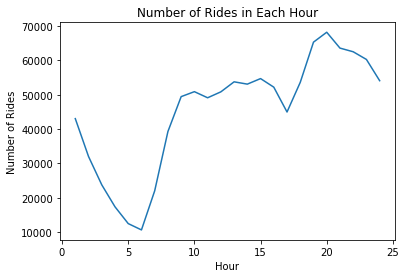

In [34]:
plt.title("Number of Rides in Each Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Rides")
data = q1.sort_values("HOUR")
plt.plot(data["HOUR"], data["RIDES"])

## 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [35]:
query = """
SELECT 
    month, AVG(distance) AS ave_distance, 
    SQRT(AVG(distance*distance) - AVG(distance)*AVG(distance)) AS std,
    COUNT(*) as count
FROM all_rides
GROUP BY month
"""

data = sqldf(query)
ci = 1.645 * data["std"]/np.sqrt(data["count"])

Text(0, 0.5, 'Average distance')

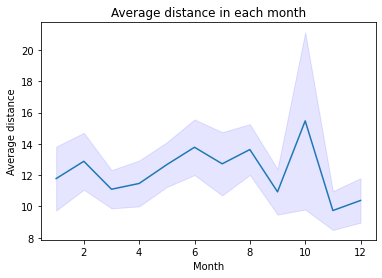

In [36]:
x = data["month"]
y = data["ave_distance"]
plt.plot(x, y)
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.title("Average distance in each month")
plt.xlabel("Month")
plt.ylabel("Average distance")

## 3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

We can see that for all three airports, Friday is the most busiest day of the week

In [37]:
def filterBox(df, box):
    df = df[
         (df["dropoff_longitude"] > box[0]) 
       & (df["dropoff_longitude"] < box[2]) 
       & (df["dropoff_latitude"] > box[1]) 
       & (df["dropoff_latitude"] < box[3])]
    return df

In [38]:
LGA = [-73.891694, 40.763007, -73.850066, 40.790436]
JFK = [-73.829375, 40.617517, -73.743544, 40.670660]
EWR = [-74.205452, 40.664547, -74.146572, 40.716221]

In [39]:
lga_rides = filterBox(all_rides, LGA)
query = """
SELECT dayofweek + 1 AS day, COUNT(*) as num_rides
FROM lga_rides
GROUP BY dayofweek
"""
lga_rides = sqldf(query)

jfk_rides = filterBox(all_rides, JFK)
query = """
SELECT dayofweek + 1 AS day, COUNT(*) as num_rides
FROM jfk_rides
GROUP BY dayofweek
"""
jfk_rides = sqldf(query)

ewr_rides = filterBox(all_rides, EWR)
query = """
SELECT dayofweek + 1 AS day, COUNT(*) as num_rides
FROM ewr_rides
GROUP BY dayofweek
"""
ewr_rides = sqldf(query)

Text(0, 0.5, 'Number of rides')

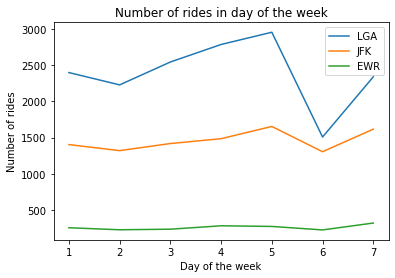

In [40]:
plt.plot(lga_rides["day"], lga_rides["num_rides"], label="LGA")
plt.plot(jfk_rides["day"], jfk_rides["num_rides"], label="JFK")
plt.plot(ewr_rides["day"], ewr_rides["num_rides"], label="EWR")
plt.legend()
plt.title("Number of rides in day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Number of rides")

## 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
To speed up the visualization and build a more friendly heatmap, we take 20K samples from all the rides.

In [41]:
map_data = all_rides
map_data = map_data.sample(20000)

In [42]:
map1 = KeplerGl(height=400)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [43]:
map1.add_data(data=map_data,name='New York City Taxi Trips')

In [45]:
map1

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '3qqt71q', 'type': …

## 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.


We do see a linear relationship between the distance and the tip amount. (About 0.5 dollar per mile)

Text(0, 0.5, 'Tips')

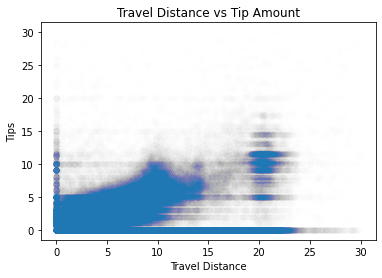

In [46]:
data = yellow_cab[(yellow_cab["distance"] < 30) & (yellow_cab["tip_amount"] < 30)]
plt.scatter(data["distance"], data["tip_amount"], alpha=0.005)
plt.title("Travel Distance vs Tip Amount")
plt.xlabel("Travel Distance")
plt.ylabel("Tips")

## 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit

We can see that it also have a linear relationship, about $y=0.15x$. (15~20% of tips)

(0.0, 150.0)

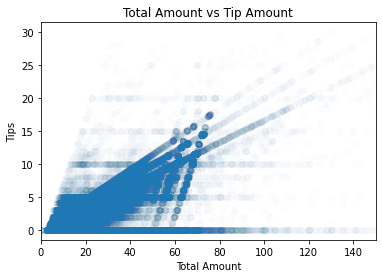

In [47]:
data = yellow_cab[(yellow_cab["total_amount"] < 150) & (yellow_cab["tip_amount"] < 30)]
plt.scatter(data["total_amount"], data["tip_amount"], alpha=0.01)
plt.title("Total Amount vs Tip Amount")
plt.xlabel("Total Amount")
plt.ylabel("Tips")
plt.xlim((0, 150))

## 7. Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.


#### 1. How does speed of the wind on a day impact the average distance of travel for both uber and yellow cab taxi? (Using yellow taxi, uber, and daily weather speed tables) Is it possible that on a windy day people prefer travel longer or shorter distance?

We can see that the wind speed doesn't impact the travel distance very much. But higher wind speed does show that people will travel in less distance, especially in Uber.

In [48]:
query = """
SELECT u.year, u.month, u.day, AVG(distance) AS avg_distance, DailyAverageWindSpeed
FROM uber u
JOIN weather_daily w
ON u.year = w.year AND u.month = w.month AND u.day = w.day
GROUP BY u.year, u.month, u.day
ORDER BY DailyAverageWindSpeed DESC
"""
uber_wind = sqldf(query)

query = """
SELECT u.year, u.month, u.day, AVG(distance) AS avg_distance, DailyAverageWindSpeed
FROM yellow_cab u
JOIN weather_daily w
ON u.year = w.year AND u.month = w.month AND u.day = w.day
GROUP BY u.year, u.month, u.day
ORDER BY DailyAverageWindSpeed DESC
"""
yellow_wind = sqldf(query)

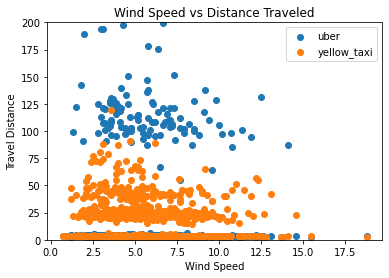

In [49]:
plt.title("Wind Speed vs Distance Traveled")
plt.scatter(uber_wind["DailyAverageWindSpeed"], uber_wind["avg_distance"], label="uber")
plt.scatter(yellow_wind["DailyAverageWindSpeed"], yellow_wind["avg_distance"], label="yellow_taxi")
plt.ylim((0, 200))
plt.xlabel("Wind Speed")
plt.ylabel("Travel Distance")
plt.legend()

#### 2. How much does people spent on Uber vs Yellow Taxi
They spent about the same amount of money in Uber and Yellow Taxi. Even the price in Uber doesn't include the tips.

Text(0, 0.5, 'fare amount in dollars')

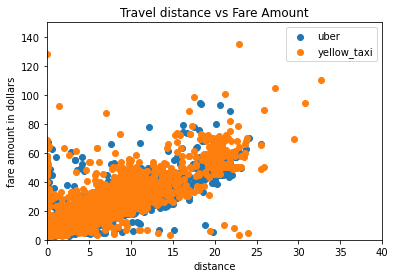

In [50]:
uber_sample = uber.sample(10000)
yellow_sample = yellow_cab.sample(10000)

plt.scatter(uber_sample["distance"], uber_sample["fare_amount"], alpha=1, label="uber")
plt.scatter(yellow_sample["distance"], yellow_sample["total_amount"], alpha=1, label="yellow_taxi")
plt.legend()
plt.ylim((0, 150))
plt.xlim((0, 40))
plt.title("Travel distance vs Fare Amount")
plt.xlabel("distance")
plt.ylabel("fare amount in dollars")

#### 3. Does people spent more money on week day or weekends?
We see that people tends to spend much less money on Saturday. Maybe because they will stay at home and travel to closer areas.

In [51]:
query = """
SELECT dayofweek + 1 AS day, AVG(fare_amount) AS avg_spent
FROM uber
GROUP BY dayofweek
ORDER BY dayofweek ASC
"""
uber_data = sqldf(query)
query = """
SELECT dayofweek + 1 AS day, AVG(total_amount) AS avg_spent
FROM yellow_cab
GROUP BY dayofweek
ORDER BY dayofweek ASC
"""
yellow_data = sqldf(query)

Text(0, 0.5, 'fare amount in dollars')

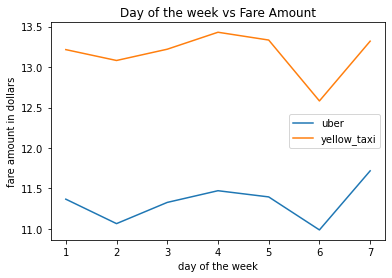

In [52]:
plt.plot(uber_data["day"], uber_data["avg_spent"], label="uber")
plt.plot(yellow_data["day"], yellow_data["avg_spent"], label="yellow_taxi")
plt.legend()
plt.title("Day of the week vs Fare Amount")
plt.xlabel("day of the week")
plt.ylabel("fare amount in dollars")